<a href="https://colab.research.google.com/github/cjs220/active_learning_ratio_estimation/blob/master/examples/mixtures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# uncomment the code below to temporarily install active_learning_ratio_estimation from source
# if you do not do this, unless you already have it installed in this environment, this notebook will not run

import os, sys, tempfile, shutil
original_dir = os.getcwd()
REPO_NAME = 'active_learning_ratio_estimation'
BRANCH = 'master'
tempdir = tempfile.gettempdir()
os.chdir(tempdir)
if os.path.exists(REPO_NAME):
  print('Removing repo')
  shutil.rmtree(REPO_NAME)
print('Cloning repo')
os.system(f'git clone --single-branch --branch {BRANCH} https://github.com/cjs220/{REPO_NAME}.git')
sys.path.insert(0, os.path.join(tempdir, REPO_NAME))
os.chdir(original_dir)

Removing repo
Cloning repo


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn import clone
from sklearn.model_selection import StratifiedShuffleSplit

from active_learning_ratio_estimation.dataset import UnparameterizedRatioDataset
from active_learning_ratio_estimation.util import ideal_classifier_probs_from_simulator, negative_log_likelihood_ratio
from active_learning_ratio_estimation.model import UnparameterizedRatioModel, DenseClassifier, FlipoutClassifier
from active_learning_ratio_estimation.model.validation import plot_calibration

tfd = tfp.distributions


np.random.seed(0)
tf.random.set_seed(0)

In [0]:
# matplotlib setup

%matplotlib inline

size=24
params = {
    'legend.fontsize': size*0.75,
    'figure.figsize': (10, 5),
    'axes.labelsize': size,
    'axes.titlesize': size,
    'xtick.labelsize': size * 0.75,
    'ytick.labelsize': size * 0.75,
    'font.family': 'sans-serif',
    'axes.titlepad': 12.5
}
plt.rcParams.update(params)

In [0]:
def triple_mixture(gamma):
    mixture_probs = [
        0.5 * (1 - gamma),
        0.5 * (1 - gamma),
        gamma
    ]
    gaussians = [
        tfd.Normal(loc=-2, scale=0.75),
        tfd.Normal(loc=0, scale=2),
        tfd.Normal(loc=1, scale=0.5)
    ]
    dist = tfd.Mixture(
        cat=tfd.Categorical(probs=mixture_probs),
        components=gaussians
    )
    return dist

In [0]:
theta_0 = 0.05
theta_1 = 0.00
n_samples_per_theta = int(1e5)


def create_dataset():
    ds = UnparameterizedRatioDataset.from_simulator(
        n_samples_per_theta=n_samples_per_theta,
        simulator_func=triple_mixture,
        theta_0=theta_0,
        theta_1=theta_1
    )
    return ds


ds = create_dataset()

In [0]:
def create_models(verbose=2):
    # hyperparams
    epochs = 10
    patience = 2
    validation_split = 0.1
    n_hidden = (10, 10)

    # regular, uncalibrated model
    regular_estimator = DenseClassifier(n_hidden=n_hidden, activation='tanh',
                                        epochs=epochs, patience=patience,
                                        validation_split=validation_split, verbose=verbose)
    regular_uncalibrated = UnparameterizedRatioModel(estimator=regular_estimator, calibration_method=None,
                                                     normalize_input=False)

    # bayesian, uncalibrated model
    bayesian_estimator = FlipoutClassifier(n_hidden=n_hidden, activation='relu',
                                           epochs=epochs, patience=patience,
                                           validation_split=validation_split, verbose=verbose)
    bayesian_uncalibrated = UnparameterizedRatioModel(estimator=bayesian_estimator, calibration_method=None,
                                                      normalize_input=False)

    # regular, calibrated model
    cv = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=1)
    regular_calibrated = UnparameterizedRatioModel(estimator=clone(regular_estimator), calibration_method='sigmoid',
                                                   normalize_input=False, cv=cv)

    models = {
        'Regular Uncalibrated': regular_uncalibrated,
        'Bayesian Uncalibrated': bayesian_uncalibrated,
        'Regular Calibrated': regular_calibrated
    }
    return models


models = create_models()

In [7]:
def fit_predict_models(models, x, dataset, verbose=True):
    y_preds = dict()
    nllrs = dict()

    for model_name, model in models.items():
        if verbose:
            print(f'\n******* Fitting {model_name} *******\n')
        model.fit(dataset)
        y_preds[model_name] = model.predict_proba(x)[:, 1]
        nllrs[model_name] = model.predict_negative_log_likelihood_ratio(x)

    y_preds['Ideal'] = ideal_classifier_probs_from_simulator(x, triple_mixture, theta_0, theta_1)
    nllrs['True'] = negative_log_likelihood_ratio(x, triple_mixture, theta_0, theta_1)

    y_preds = pd.DataFrame(y_preds, index=x)
    nllrs = pd.DataFrame(nllrs, index=x)
    return y_preds, nllrs


x = np.linspace(-5, 5, int(1e4))
y_preds, nllrs = fit_predict_models(models, x, ds)


******* Fitting Regular Uncalibrated *******

Epoch 1/10
5625/5625 - 7s - loss: 0.6926 - accuracy: 0.5138 - val_loss: 0.6919 - val_accuracy: 0.5164
Epoch 2/10
5625/5625 - 6s - loss: 0.6924 - accuracy: 0.5149 - val_loss: 0.6918 - val_accuracy: 0.5065
Epoch 3/10
5625/5625 - 7s - loss: 0.6922 - accuracy: 0.5156 - val_loss: 0.6915 - val_accuracy: 0.5153
Epoch 4/10
5625/5625 - 6s - loss: 0.6922 - accuracy: 0.5156 - val_loss: 0.6918 - val_accuracy: 0.5142
Epoch 5/10
5625/5625 - 6s - loss: 0.6922 - accuracy: 0.5165 - val_loss: 0.6921 - val_accuracy: 0.5142

******* Fitting Bayesian Uncalibrated *******

Epoch 1/10
Instructions for updating:
Please use `layer.add_weight` method instead.
5625/5625 - 9s - loss: 0.6944 - accuracy: 0.5081 - val_loss: 0.6935 - val_accuracy: 0.5155
Epoch 2/10
5625/5625 - 8s - loss: 0.6935 - accuracy: 0.5164 - val_loss: 0.6930 - val_accuracy: 0.5156
Epoch 3/10
5625/5625 - 8s - loss: 0.6931 - accuracy: 0.5176 - val_loss: 0.6925 - val_accuracy: 0.5168
Epoch 4/10
5625/

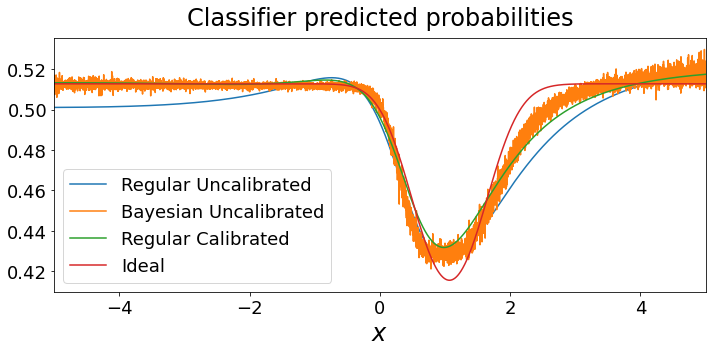

In [8]:
# Plot predictions for classifier decision function
y_preds.plot()
plt.xlim([-5, 5])
plt.title('Classifier predicted probabilities')
plt.xlabel('$x$')
plt.tight_layout()
plt.show()

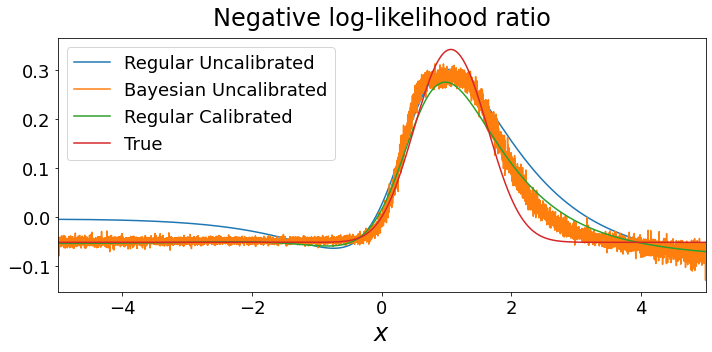

In [9]:
# Plot predictions for negative log likelihood ratio
nllrs.plot()
plt.xlim([-5, 5])
# plt.ylim([-0.2, 0.5])
plt.title('Negative log-likelihood ratio')
plt.xlabel('$x$')
plt.tight_layout()
plt.show()

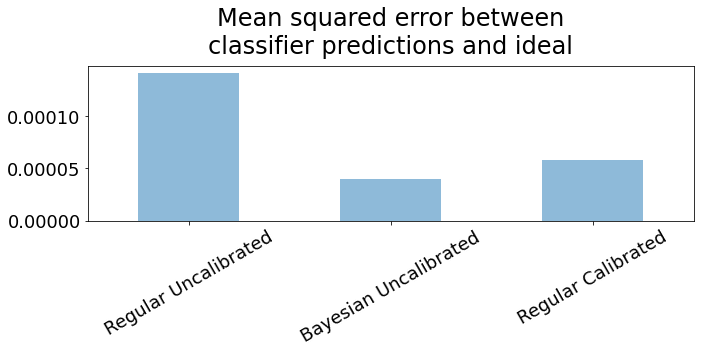

In [10]:
def calculate_mse(y_preds):
    mses = pd.Series(dtype=float)

    for model_name in y_preds:
        if model_name == 'Ideal':
            continue
        mse = np.mean((y_preds[model_name] - y_preds['Ideal']) ** 2)
        mses[model_name] = mse

    return mses


mses = calculate_mse(y_preds)
f = plt.figure()
mses.plot.bar(rot=30, alpha=0.5)
plt.title('Mean squared error between\nclassifier predictions and ideal')
plt.tight_layout()
plt.show()

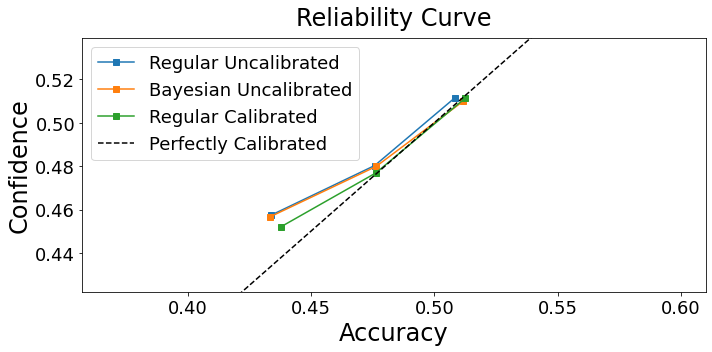

In [11]:
# plot calibration curves and scores
calibration_curves, scores = plot_calibration(ratio_models=models, dataset=ds, n_data=int(1e4), n_bins=20)
plt.xlabel('Accuracy')
plt.ylabel('Confidence')
plt.show()

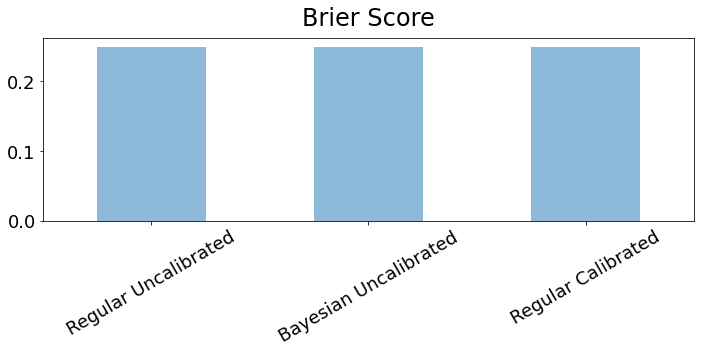

In [12]:
pd.Series(scores['Brier Score']).plot.bar(rot=30, alpha=0.5)
plt.title('Brier Score')
plt.tight_layout()
plt.show()

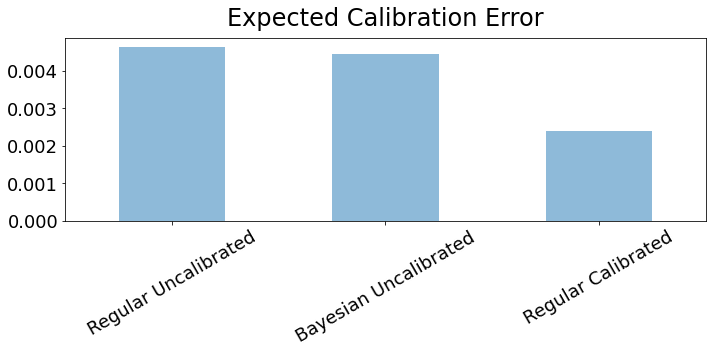

In [13]:
pd.Series(scores['Expected Calibration Error']).plot.bar(rot=30, alpha=0.5)
plt.title('Expected Calibration Error')
plt.tight_layout()
plt.show()

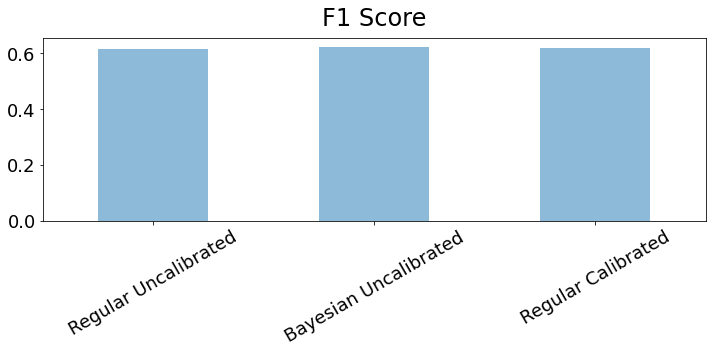

In [14]:
pd.Series(scores['F1 Score']).plot.bar(rot=30, alpha=0.5)
plt.title('F1 Score')
plt.tight_layout()
plt.show()

In [15]:
# Repeat the process, and find the MSE with error bars
n_repeats = 4
all_results = [mses]

for i in range(n_repeats):
    ds = create_dataset()
    models = create_models(verbose=False)
    print(f'Refitting models {i+1}/{n_repeats}')
    y_preds, _ = fit_predict_models(models, x, ds, verbose=False)
    all_results.append(calculate_mse(y_preds))

Refitting models 1/4
Refitting models 2/4
Refitting models 3/4
Refitting models 4/4


In [0]:
mses = pd.concat(all_results, axis=1).T
n_bootstrap = 500
bootstrap_samples = np.stack([mses.sample(n=len(mses), replace=True) for _ in range(n_bootstrap)])
bootstrap_means = bootstrap_samples.mean(axis=1)
bootstrap_mean = bootstrap_means.mean(axis=0)
bootstrap_std = bootstrap_means.std(axis=0)

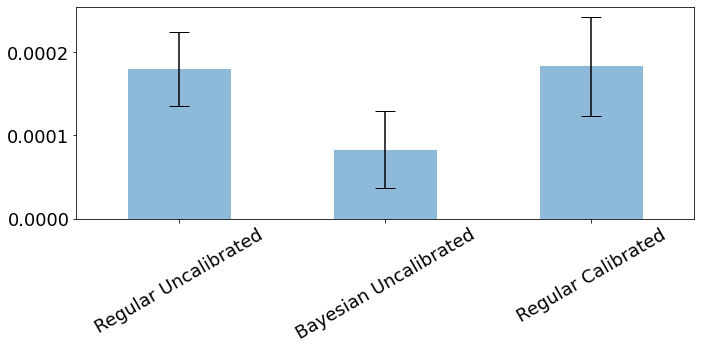

In [17]:
pd.Series(bootstrap_mean, index=mses.columns).plot.bar(
    yerr=bootstrap_std,
    alpha=0.5,
    capsize=10,
    rot=30
)
plt.tight_layout()
plt.show()